In [1]:
import numpy as np
import pickle

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This code below is used to index into the data and retrieve the 14 features. The last timestep is ignored. Look at the comments below to see how to retrieve the subset of features - the original vehicle features will correspond to 1, 2, 3, 4, 5, while the pedestrian features correspond to 6 and 7, the cyclist is 8 and 9, and the roadgraph features are 10, 11, 12, and 13. We played around including a subset of the features since utilizing all 13 features produced bad results.

In [27]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
# data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
# another_data = data[:, :, 1:8]
# new_data = data[:, :, 10:]
# data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2933, 91, 14)
Shape of full dataset: (2933, 90, 7)
(2346, 80, 7) (587, 80, 7) (2346, 10, 7) (587, 10, 7)


# Initial External Actors Implementation - Base Model


Vehicle features + pedestrian features + cyclist features + roadgraph features

(2933, 91, 14)
Shape of full dataset: (2933, 90, 13)
(2346, 80, 13) (587, 80, 13) (2346, 10, 13) (587, 10, 13)
Epoch [1/150], Training Loss: 5854.5457, LR: 0.009999
Validation Loss: 2925.5383
Epoch [2/150], Training Loss: 5876.8082, LR: 0.009996
Validation Loss: 2927.9398
Epoch [3/150], Training Loss: 5920.7985, LR: 0.009990
Validation Loss: 2930.7083
Epoch [4/150], Training Loss: 5798.6876, LR: 0.009982
Validation Loss: 2933.1161
Epoch [5/150], Training Loss: 5780.7201, LR: 0.009973
Validation Loss: 2932.9113
Epoch [6/150], Training Loss: 5797.1730, LR: 0.009961
Validation Loss: 2939.2974
Epoch [7/150], Training Loss: 5771.2924, LR: 0.009946
Validation Loss: 2942.8101
Epoch [8/150], Training Loss: 5763.6730, LR: 0.009930
Validation Loss: 2946.9421
Epoch [9/150], Training Loss: 5775.4903, LR: 0.009911
Validation Loss: 2952.2785
Epoch [10/150], Training Loss: 6003.2026, LR: 0.009891
Validation Loss: 2941.6260
Epoch [11/150], Training Loss: 5736.6223, LR: 0.009868
Validation Loss: 2941.8

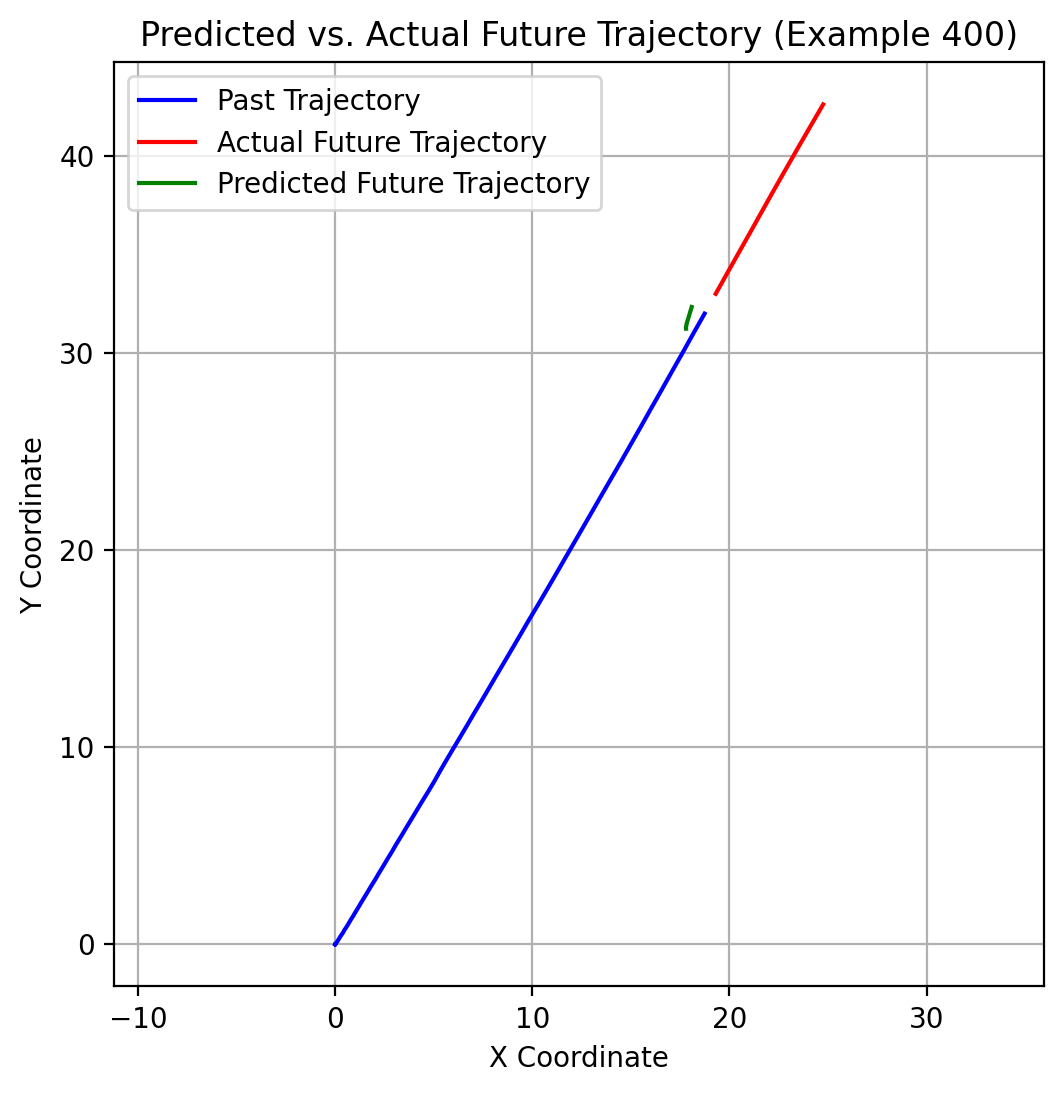

In [29]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
# data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
# another_data = data[:, :, 1:8]
# new_data = data[:, :, 10:]
# data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)



import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        # want to take the last layer so that you are left with (batch_size, hidden_size)
        out = self.fc(hn[-1])
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)
        pred_position = cum_disp + last_input_state.unsqueeze(1)
        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)


from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize model
input_size = X_train.shape[2]  # Number of features
# hidden_size = 64  # You can adjust this

hidden_size = 32  # You can adjust this

# input_size = 5
# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# Train the model with cosine decay learning rate


train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# Initial External Actors Implementation - Base Model


Vehicle features + pedestrian features + roadgraph features

(2933, 91, 14)
Shape of full dataset: (2933, 90, 11)
(2346, 80, 11) (587, 80, 11) (2346, 10, 11) (587, 10, 11)
Epoch [1/150], Training Loss: 5892.9739, LR: 0.009999
Validation Loss: 2895.2565
Epoch [2/150], Training Loss: 5859.9676, LR: 0.009996
Validation Loss: 2874.9894
Epoch [3/150], Training Loss: 5847.1091, LR: 0.009990
Validation Loss: 2866.3007
Epoch [4/150], Training Loss: 5776.0462, LR: 0.009982
Validation Loss: 2852.6233
Epoch [5/150], Training Loss: 5763.8391, LR: 0.009973
Validation Loss: 2850.0976
Epoch [6/150], Training Loss: 5740.5195, LR: 0.009961
Validation Loss: 2844.2600
Epoch [7/150], Training Loss: 5791.9077, LR: 0.009946
Validation Loss: 2835.8510
Epoch [8/150], Training Loss: 5776.9323, LR: 0.009930
Validation Loss: 2832.1389
Epoch [9/150], Training Loss: 5776.5691, LR: 0.009911
Validation Loss: 2832.2046
Epoch [10/150], Training Loss: 5719.9728, LR: 0.009891
Validation Loss: 2826.4604
Epoch [11/150], Training Loss: 5752.4675, LR: 0.009868
Validation Loss: 2829.8

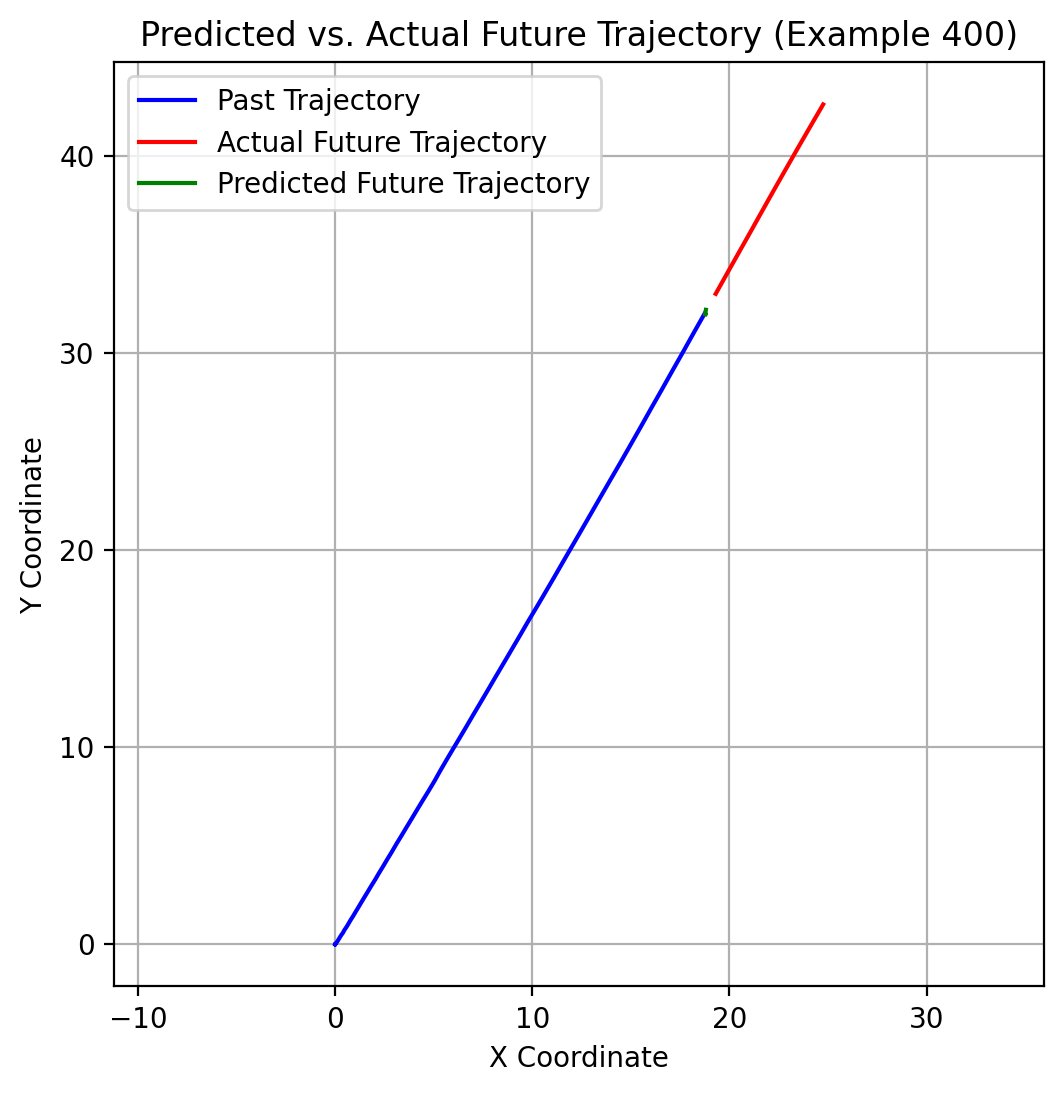

In [32]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
# data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
# data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
another_data = data[:, :, 1:8]
new_data = data[:, :, 10:]
data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)



import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        # want to take the last layer so that you are left with (batch_size, hidden_size)
        out = self.fc(hn[-1])
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)
        pred_position = cum_disp + last_input_state.unsqueeze(1)
        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)


from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize model
input_size = X_train.shape[2]  # Number of features
# hidden_size = 64  # You can adjust this

hidden_size = 32  # You can adjust this

# input_size = 5
# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# Train the model with cosine decay learning rate


train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# Initial External Actors Implementation - Base Model


Vehicle features + pedestrian features

(2933, 91, 14)
Shape of full dataset: (2933, 90, 7)
(2346, 80, 7) (587, 80, 7) (2346, 10, 7) (587, 10, 7)
Epoch [1/150], Training Loss: 5752.9141, LR: 0.009999
Validation Loss: 2770.7532
Epoch [2/150], Training Loss: 5443.1928, LR: 0.009996
Validation Loss: 2615.6731
Epoch [3/150], Training Loss: 5231.7133, LR: 0.009990
Validation Loss: 2567.6890
Epoch [4/150], Training Loss: 5082.0847, LR: 0.009982
Validation Loss: 2479.0166
Epoch [5/150], Training Loss: 4996.0293, LR: 0.009973
Validation Loss: 2527.3081
Epoch [6/150], Training Loss: 4965.0689, LR: 0.009961
Validation Loss: 2515.2166
Epoch [7/150], Training Loss: 4996.6356, LR: 0.009946
Validation Loss: 2547.8756
Epoch [8/150], Training Loss: 4917.3007, LR: 0.009930
Validation Loss: 2486.1003
Epoch [9/150], Training Loss: 4853.7381, LR: 0.009911
Validation Loss: 2457.9353
Epoch [10/150], Training Loss: 4891.8907, LR: 0.009891
Validation Loss: 2452.5165
Epoch [11/150], Training Loss: 4855.0802, LR: 0.009868
Validation Loss: 2589.2818
E

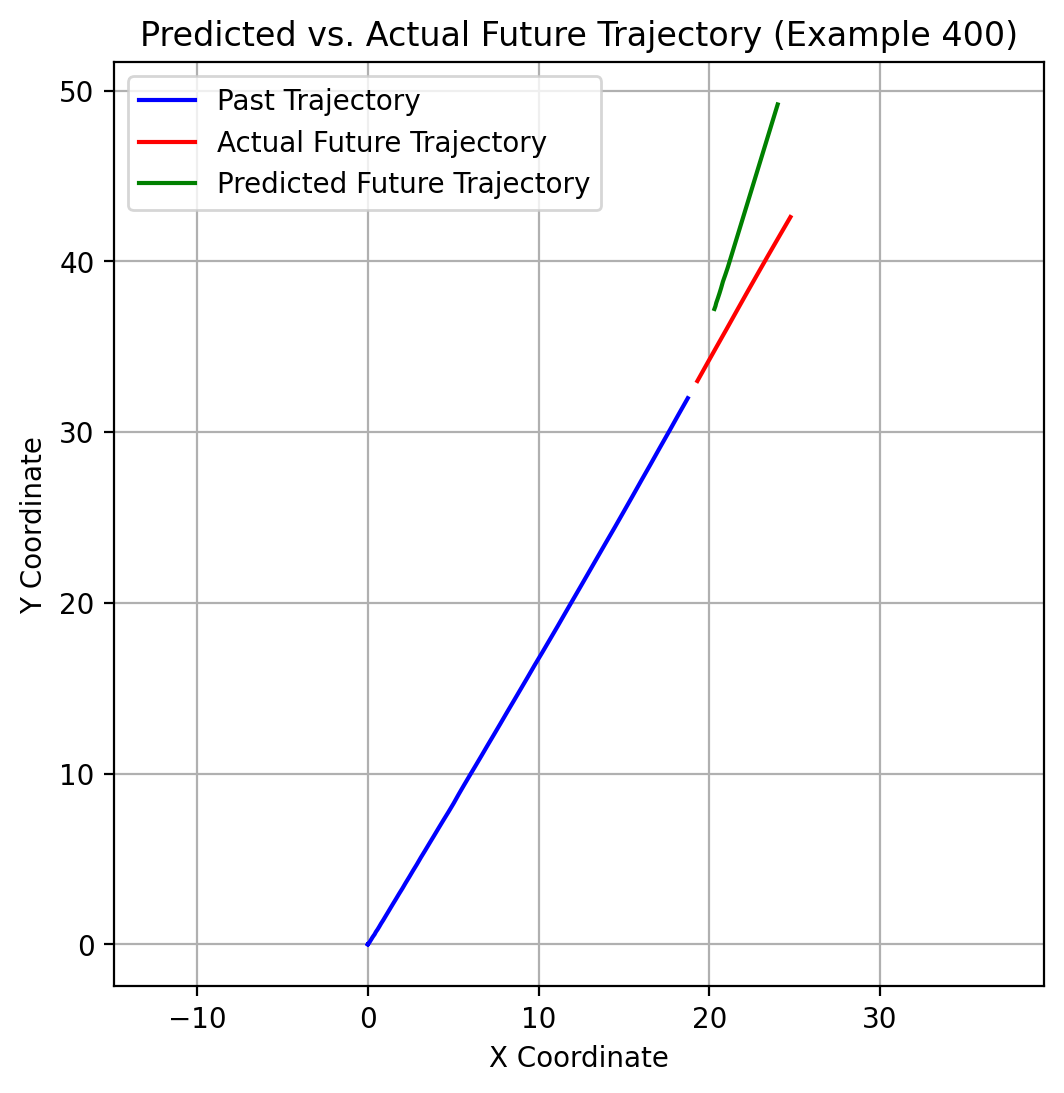

In [33]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
# data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
# another_data = data[:, :, 1:8]
# new_data = data[:, :, 10:]
# data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)




import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        # want to take the last layer so that you are left with (batch_size, hidden_size)
        out = self.fc(hn[-1])
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)
        pred_position = cum_disp + last_input_state.unsqueeze(1)
        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)


from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize model
input_size = X_train.shape[2]  # Number of features
# hidden_size = 64  # You can adjust this

hidden_size = 32  # You can adjust this

# input_size = 5
# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# Train the model with cosine decay learning rate


train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# External Actors - Transformer Architecture

vehicle features + pedestrian + cyclist + roadgraph


(2933, 91, 14)
Shape of full dataset: (2933, 90, 13)
(2346, 80, 13) (587, 80, 13) (2346, 10, 13) (587, 10, 13)
Epoch [1/150], Training Loss: 5865.9057, LR: 0.009999
Validation Loss: 2874.4701
Epoch [2/150], Training Loss: 5815.9133, LR: 0.009996
Validation Loss: 2884.6061
Epoch [3/150], Training Loss: 5793.4764, LR: 0.009990
Validation Loss: 2911.4372
Epoch [4/150], Training Loss: 5767.1749, LR: 0.009982
Validation Loss: 2925.8653
Epoch [5/150], Training Loss: 5736.5528, LR: 0.009973
Validation Loss: 2951.0395
Epoch [6/150], Training Loss: 5747.7059, LR: 0.009961
Validation Loss: 2965.2906
Epoch [7/150], Training Loss: 5718.2373, LR: 0.009946
Validation Loss: 2979.5630
Epoch [8/150], Training Loss: 5667.4733, LR: 0.009930
Validation Loss: 2991.9993
Epoch [9/150], Training Loss: 5670.1098, LR: 0.009911
Validation Loss: 3015.6857
Epoch [10/150], Training Loss: 5703.0308, LR: 0.009891
Validation Loss: 3024.2024
Epoch [11/150], Training Loss: 5635.8138, LR: 0.009868
Validation Loss: 3061.8

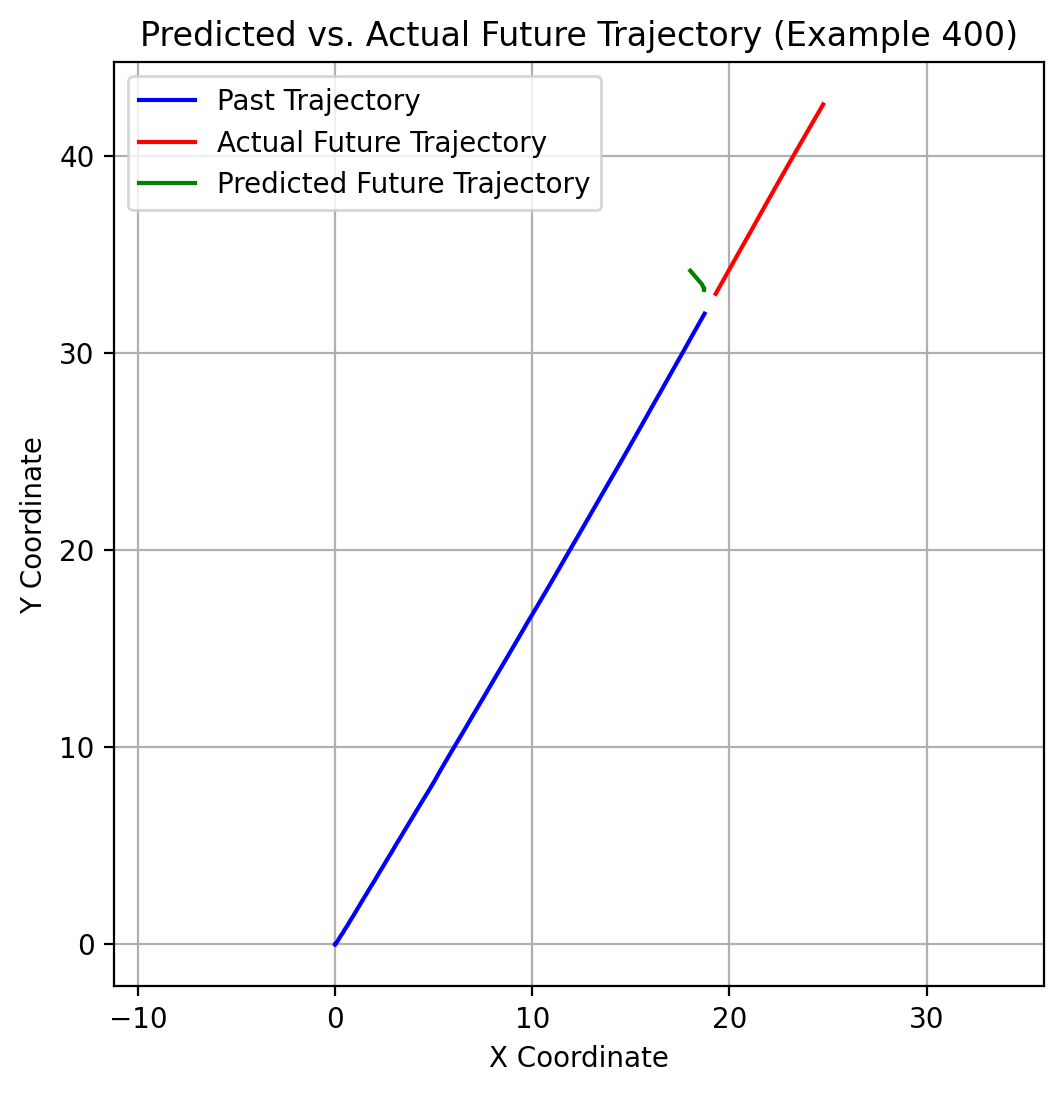

In [34]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
# data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
# another_data = data[:, :, 1:8]
# new_data = data[:, :, 10:]
# data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


import torch
import torch.nn as nn

class TrajectoryTransformer(nn.Module):
    def __init__(self, input_size, model_dim, num_heads, num_layers, output_features=2, output_timesteps=10, max_seq_length=50):
        super(TrajectoryTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(max_seq_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=4 * model_dim,
            dropout=0.5 #dropout=0.1
        )
        self.fc = nn.Linear(model_dim, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        batch_size, seq_length, input_size = x.size()
        src = self.embedding(x) + self.positional_encoding[:seq_length]  # Add positional encoding
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, model_dim)

        tgt = torch.zeros_like(src)  # Dummy target (for autoregressive tasks, replace with actual decoder inputs if needed)

        # Pass through the Transformer
        output = self.transformer(src, tgt)
        output = output[-1]  # Take the last sequence position
        output = self.fc(output)
        return output.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, 2)



class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)
        pred_position = cum_disp + last_input_state.unsqueeze(1)
        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)
from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this

# hidden_size = 32  # You can adjust this

# input_size = 5
# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# Train the model with cosine decay learning rate


train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)



# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)
# 492 -> no motion in x direction, only movement in y-direction

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# External Actors - Transformer Architecture

vehicle features + pedestrian + roadgraph

(2933, 91, 14)
Shape of full dataset: (2933, 90, 11)
(2346, 80, 11) (587, 80, 11) (2346, 10, 11) (587, 10, 11)
Epoch [1/150], Training Loss: 5857.2627, LR: 0.009999
Validation Loss: 2855.4780
Epoch [2/150], Training Loss: 5834.6070, LR: 0.009996
Validation Loss: 2824.5766
Epoch [3/150], Training Loss: 5793.2934, LR: 0.009990
Validation Loss: 2819.2040
Epoch [4/150], Training Loss: 5805.2911, LR: 0.009982
Validation Loss: 2817.8729
Epoch [5/150], Training Loss: 5785.4206, LR: 0.009973
Validation Loss: 2802.7082
Epoch [6/150], Training Loss: 5763.2500, LR: 0.009961
Validation Loss: 2807.6753
Epoch [7/150], Training Loss: 5751.4888, LR: 0.009946
Validation Loss: 2801.1721
Epoch [8/150], Training Loss: 5733.3005, LR: 0.009930
Validation Loss: 2797.3528
Epoch [9/150], Training Loss: 5701.8074, LR: 0.009911
Validation Loss: 2808.6217
Epoch [10/150], Training Loss: 5681.8105, LR: 0.009891
Validation Loss: 2838.9586
Epoch [11/150], Training Loss: 5741.6122, LR: 0.009868
Validation Loss: 2830.0

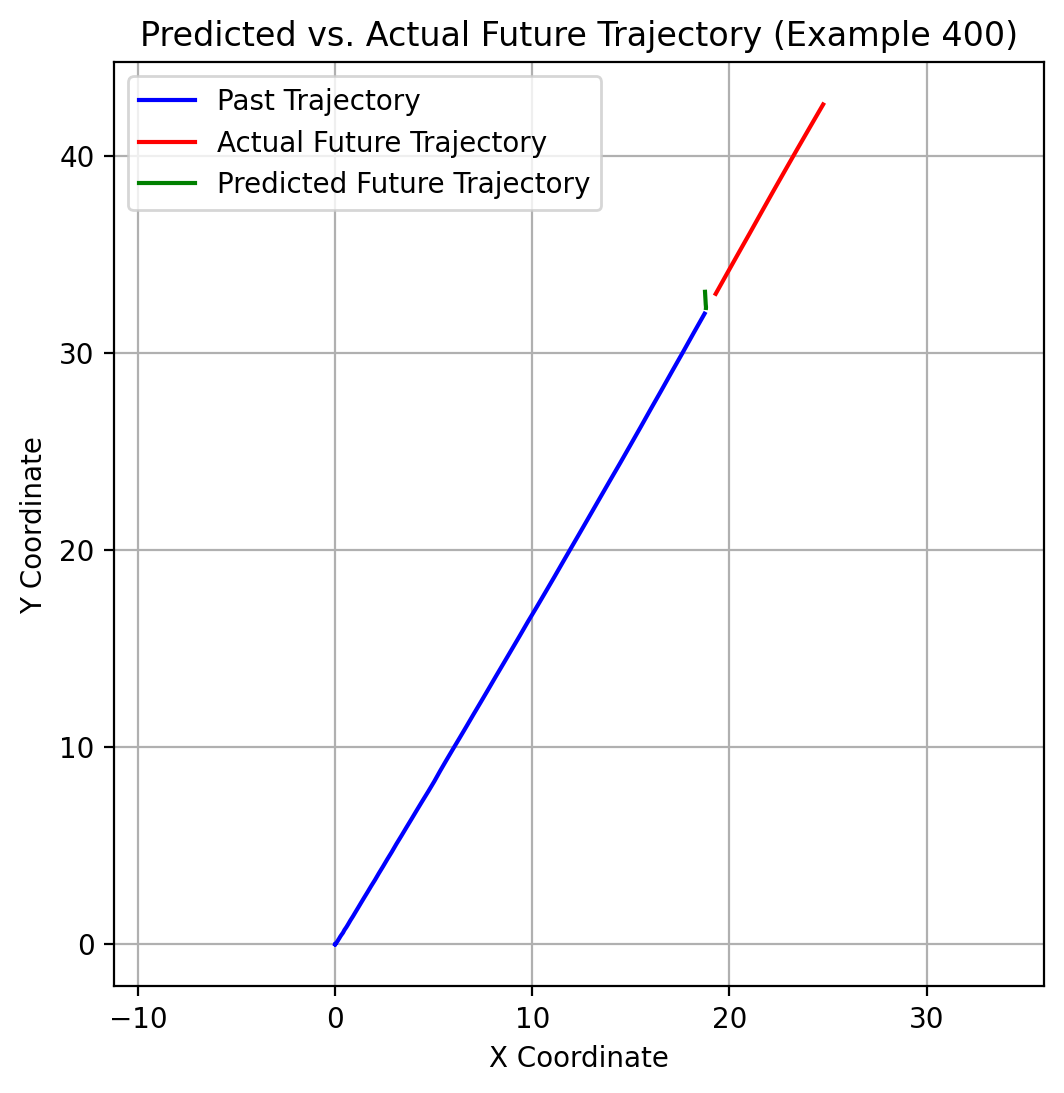

In [35]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
# data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
# data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
another_data = data[:, :, 1:8]
new_data = data[:, :, 10:]
data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)




import torch
import torch.nn as nn

class TrajectoryTransformer(nn.Module):
    def __init__(self, input_size, model_dim, num_heads, num_layers, output_features=2, output_timesteps=10, max_seq_length=50):
        super(TrajectoryTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(max_seq_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=4 * model_dim,
            dropout=0.5 #dropout=0.1
        )
        self.fc = nn.Linear(model_dim, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        batch_size, seq_length, input_size = x.size()
        src = self.embedding(x) + self.positional_encoding[:seq_length]  # Add positional encoding
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, model_dim)

        tgt = torch.zeros_like(src)  # Dummy target (for autoregressive tasks, replace with actual decoder inputs if needed)

        # Pass through the Transformer
        output = self.transformer(src, tgt)
        output = output[-1]  # Take the last sequence position
        output = self.fc(output)
        return output.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, 2)



class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)
        pred_position = cum_disp + last_input_state.unsqueeze(1)
        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)
from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this

# hidden_size = 32  # You can adjust this

# input_size = 5
# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# Train the model with cosine decay learning rate


train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)



# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)
# 492 -> no motion in x direction, only movement in y-direction

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# External Actors - Transformer Architecture

vehicle features + pedestrian

(2933, 91, 14)
Shape of full dataset: (2933, 90, 7)
(2346, 80, 7) (587, 80, 7) (2346, 10, 7) (587, 10, 7)
Epoch [1/150], Training Loss: 5531.5257, LR: 0.009999
Validation Loss: 2516.7256
Epoch [2/150], Training Loss: 5038.1711, LR: 0.009996
Validation Loss: 2469.7937
Epoch [3/150], Training Loss: 4928.2395, LR: 0.009990
Validation Loss: 2483.1181
Epoch [4/150], Training Loss: 4829.2535, LR: 0.009982
Validation Loss: 2445.4357
Epoch [5/150], Training Loss: 4769.5185, LR: 0.009973
Validation Loss: 2399.3588
Epoch [6/150], Training Loss: 4747.6634, LR: 0.009961
Validation Loss: 2442.4629
Epoch [7/150], Training Loss: 4742.8016, LR: 0.009946
Validation Loss: 2492.7573
Epoch [8/150], Training Loss: 4748.3106, LR: 0.009930
Validation Loss: 2406.6889
Epoch [9/150], Training Loss: 4717.6551, LR: 0.009911
Validation Loss: 2421.5779
Epoch [10/150], Training Loss: 4677.1587, LR: 0.009891
Validation Loss: 2386.2202
Epoch [11/150], Training Loss: 4591.9108, LR: 0.009868
Validation Loss: 2360.8525
E

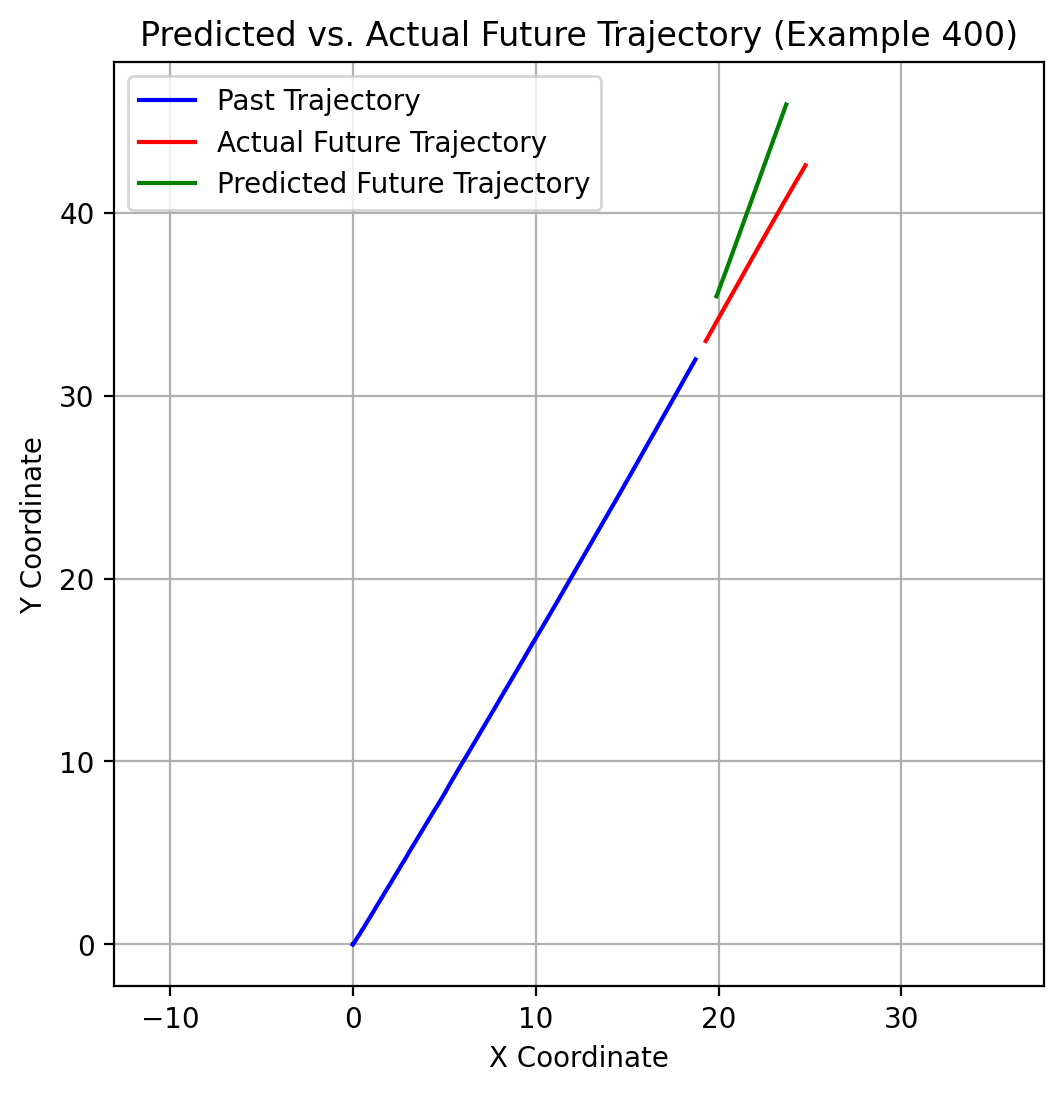

In [36]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
# data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
# another_data = data[:, :, 1:8]
# new_data = data[:, :, 10:]
# data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


import torch
import torch.nn as nn

class TrajectoryTransformer(nn.Module):
    def __init__(self, input_size, model_dim, num_heads, num_layers, output_features=2, output_timesteps=10, max_seq_length=50):
        super(TrajectoryTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(max_seq_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=4 * model_dim,
            dropout=0.5 #dropout=0.1
        )
        self.fc = nn.Linear(model_dim, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        batch_size, seq_length, input_size = x.size()
        src = self.embedding(x) + self.positional_encoding[:seq_length]  # Add positional encoding
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, model_dim)

        tgt = torch.zeros_like(src)  # Dummy target (for autoregressive tasks, replace with actual decoder inputs if needed)

        # Pass through the Transformer
        output = self.transformer(src, tgt)
        output = output[-1]  # Take the last sequence position
        output = self.fc(output)
        return output.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, 2)



class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)
        pred_position = cum_disp + last_input_state.unsqueeze(1)
        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)
from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this

# hidden_size = 32  # You can adjust this

# input_size = 5
# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# Train the model with cosine decay learning rate


train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)



# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)
# 492 -> no motion in x direction, only movement in y-direction

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# External Actors Implementation - Positional Encoding, Dropout, Single Headed Attention

Vehicle features + pedestrian + cyclist + roadgraph

(2933, 91, 14)
Shape of full dataset: (2933, 90, 13)
(2346, 80, 13) (587, 80, 13) (2346, 10, 13) (587, 10, 13)
Epoch [1/150], Training Loss: 7040.8871, LR: 0.009999
Validation Loss: 3468.6901
Epoch [2/150], Training Loss: 7018.4015, LR: 0.009996
Validation Loss: 3613.5595
Epoch [3/150], Training Loss: 6979.1865, LR: 0.009990
Validation Loss: 3457.9062
Epoch [4/150], Training Loss: 6894.6546, LR: 0.009982
Validation Loss: 3592.6057
Epoch [5/150], Training Loss: 6866.7672, LR: 0.009973
Validation Loss: 3588.0769
Epoch [6/150], Training Loss: 6841.2560, LR: 0.009961
Validation Loss: 3598.7681
Epoch [7/150], Training Loss: 6800.8017, LR: 0.009946
Validation Loss: 3590.1279
Epoch [8/150], Training Loss: 6758.1793, LR: 0.009930
Validation Loss: 3886.2966
Epoch [9/150], Training Loss: 6657.9208, LR: 0.009911
Validation Loss: 3750.9864
Epoch [10/150], Training Loss: 6741.7827, LR: 0.009891
Validation Loss: 3643.7696
Epoch [11/150], Training Loss: 6735.6515, LR: 0.009868
Validation Loss: 3735.2

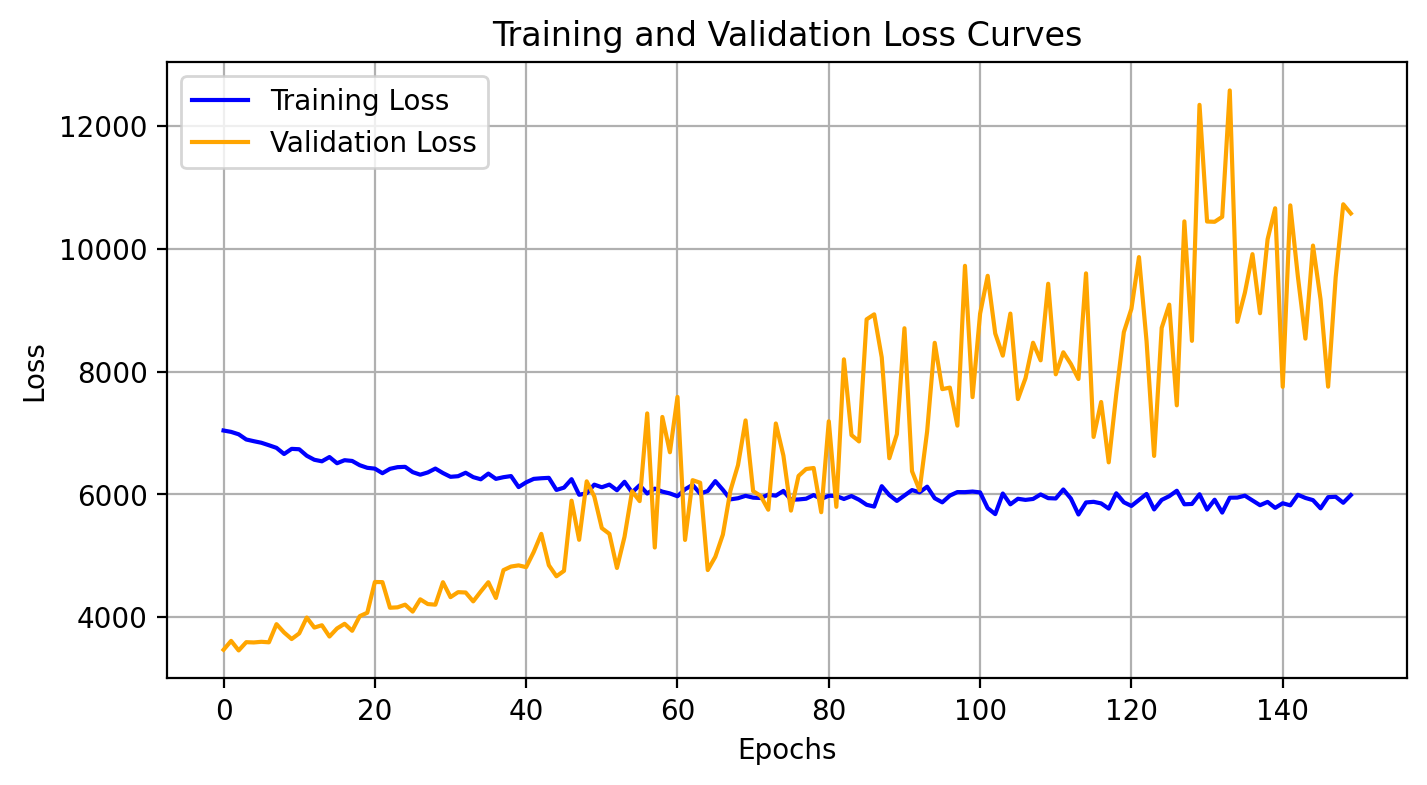

Mean ADE: 11.287931442260742


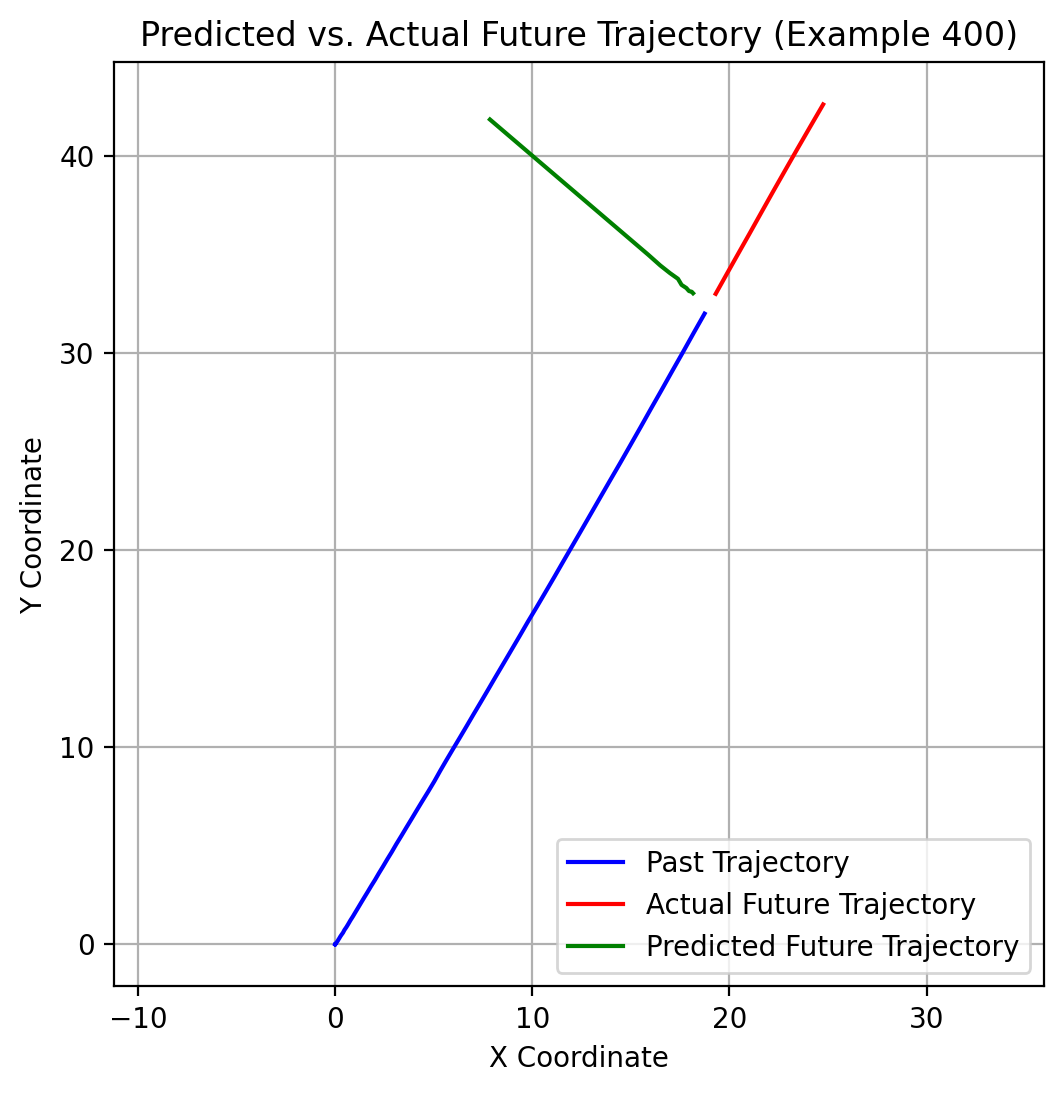

In [37]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
# data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
# another_data = data[:, :, 1:8]
# new_data = data[:, :, 10:]
# data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


#Kavya and Srishti
# External Actors added
import math
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5):
        super(TrajectoryLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_features = output_features
        self.output_timesteps = output_timesteps
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer

        # Attention mechanism
        self.attention = nn.Linear(hidden_size, 1)  # To compute attention scores
        self.softmax = nn.Softmax(dim=1)  # For normalizing attention scores

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(32, output_features * output_timesteps)
        )

    def positional_encoding(self, seq_length, dim):
        # Create the positional encoding matrix
        pos = torch.arange(seq_length, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(dim, dtype=torch.float32).unsqueeze(0)

        # Compute sinusoidal functions
        angle_rates = 1 / (10000 ** (2 * (i // 2) / dim))
        angle_rads = pos * angle_rates

        # Apply sin to even indices and cos to odd indices
        pos_enc = torch.zeros((seq_length, dim))
        pos_enc[:, 0::2] = torch.sin(angle_rads[:, 0::2])  # sin for even indices
        pos_enc[:, 1::2] = torch.cos(angle_rads[:, 1::2])  # cos for odd indices

        return pos_enc

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Add positional encoding
        pos_enc = self.positional_encoding(seq_length, self.input_size).to(x.device)
        x = x + pos_enc.unsqueeze(0)  # Broadcast to batch size

        # LSTM forward pass
        lstm_out, (hn, _) = self.lstm(x)

        # Compute attention scores
        attn_scores = self.attention(lstm_out)  # (batch_size, seq_length, 1)
        attn_weights = self.softmax(attn_scores)  # Normalize to get weights

        # Apply attention weights to LSTM outputs
        weighted_output = lstm_out * attn_weights  # (batch_size, seq_length, hidden_size)
        context_vector = torch.sum(weighted_output, dim=1)  # Sum across seq_length

        # Apply dropout and fully connected layers
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)  # (batch_size, output_timesteps * output_features)
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.2):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        # total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        total_loss = 2 * position_loss + velocity_loss + 0.5 * smoothness_loss + 2 * terminal_position_loss

        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            # added this to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)

            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 128  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


# External Actors Implementation - Positional Encoding, Dropout, Single Headed Attention

Vehicle features + pedestrian + roadgraph

(2933, 91, 14)
Shape of full dataset: (2933, 90, 11)
(2346, 80, 11) (587, 80, 11) (2346, 10, 11) (587, 10, 11)
Epoch [1/150], Training Loss: 7053.6985, LR: 0.009999
Validation Loss: 3464.6730
Epoch [2/150], Training Loss: 7032.5724, LR: 0.009996
Validation Loss: 3456.6255
Epoch [3/150], Training Loss: 7007.5237, LR: 0.009990
Validation Loss: 3438.0866
Epoch [4/150], Training Loss: 6974.9212, LR: 0.009982
Validation Loss: 3438.1576
Epoch [5/150], Training Loss: 6932.6699, LR: 0.009973
Validation Loss: 3460.8765
Epoch [6/150], Training Loss: 6944.9791, LR: 0.009961
Validation Loss: 3479.2930
Epoch [7/150], Training Loss: 6899.9971, LR: 0.009946
Validation Loss: 3469.0558
Epoch [8/150], Training Loss: 6803.0879, LR: 0.009930
Validation Loss: 3401.3241
Epoch [9/150], Training Loss: 6822.3241, LR: 0.009911
Validation Loss: 3467.9492
Epoch [10/150], Training Loss: 6861.5277, LR: 0.009891
Validation Loss: 3403.5501
Epoch [11/150], Training Loss: 6802.1980, LR: 0.009868
Validation Loss: 3449.2

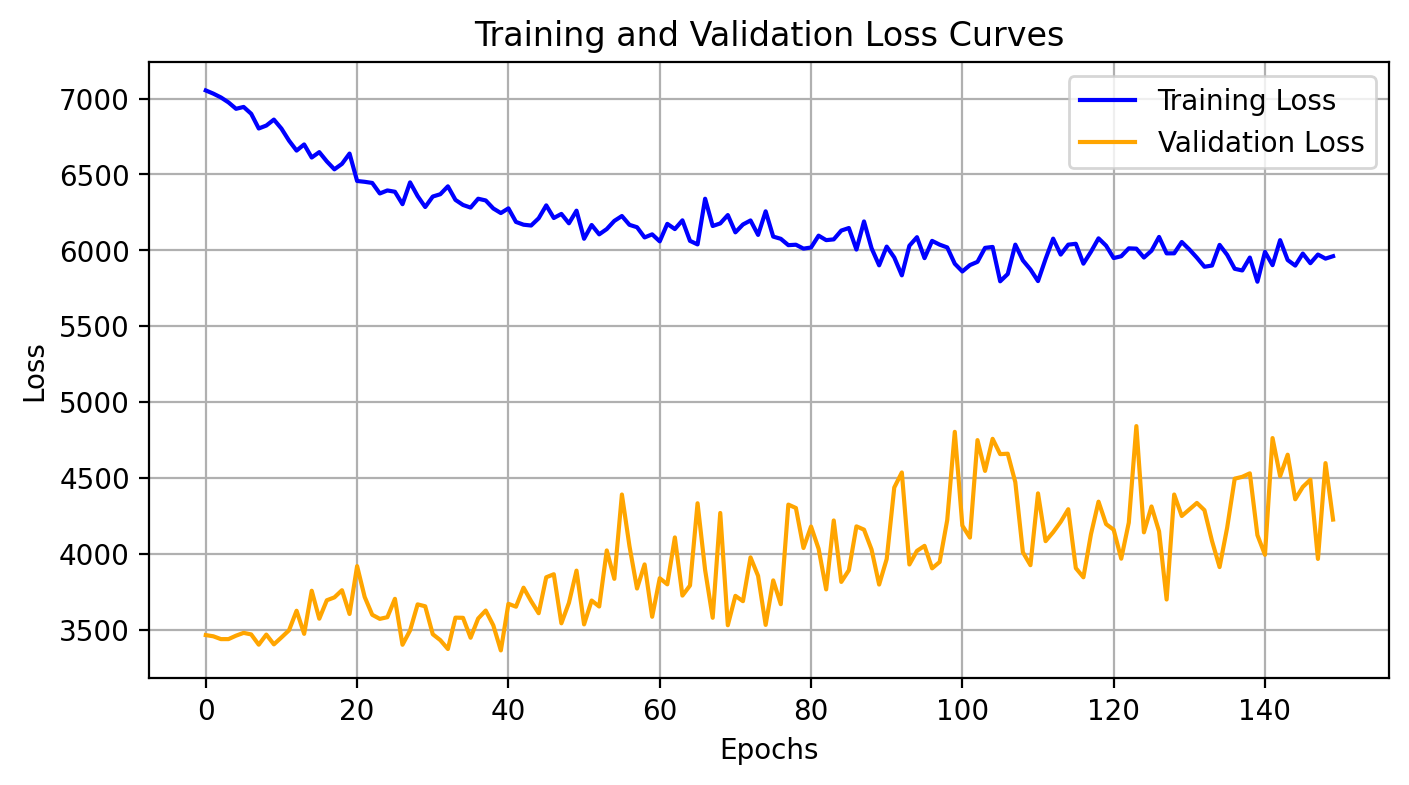

Mean ADE: 5.752474308013916


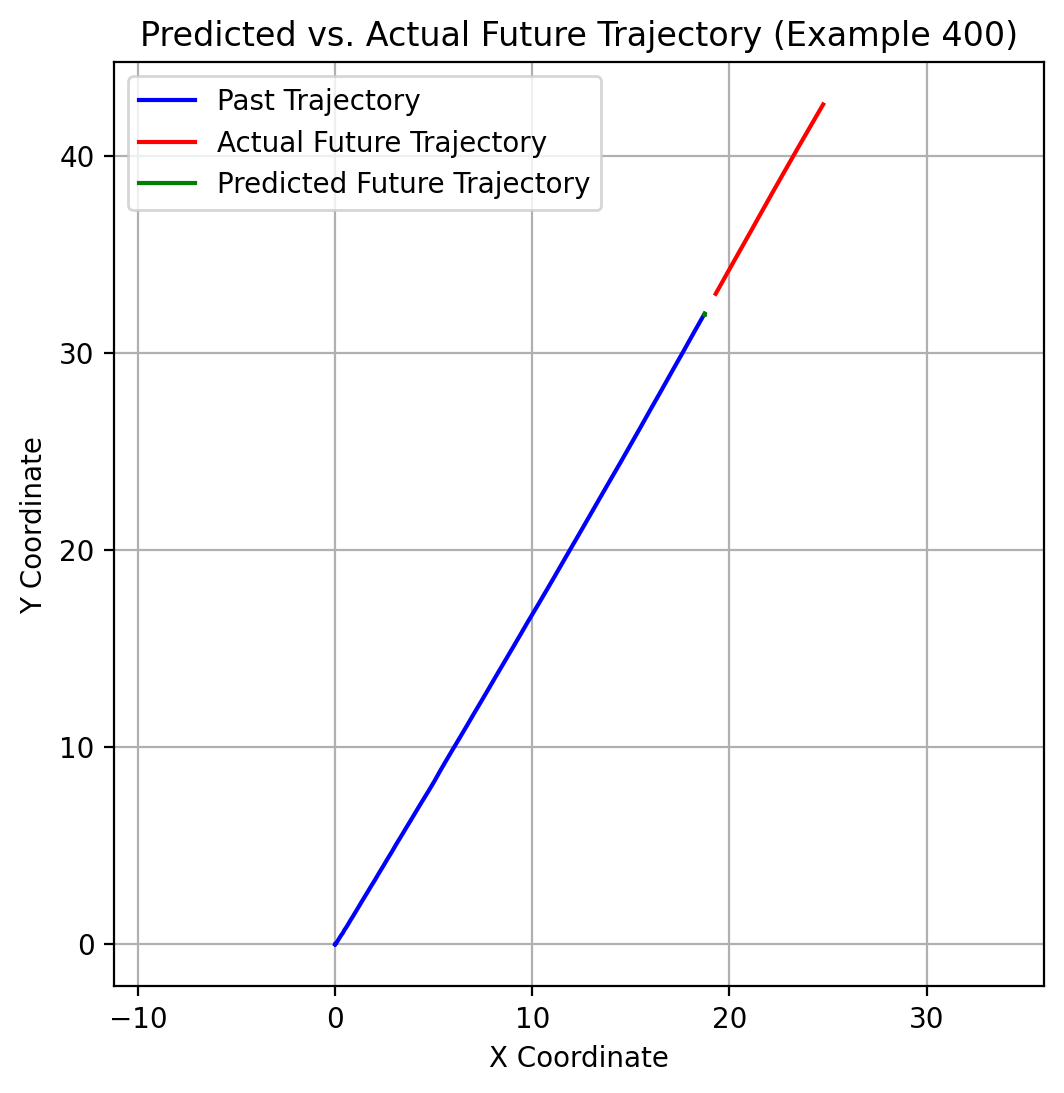

In [38]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
# data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
# data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
another_data = data[:, :, 1:8]
new_data = data[:, :, 10:]
data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)




#Kavya and Srishti
# External Actors added
import math
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5):
        super(TrajectoryLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_features = output_features
        self.output_timesteps = output_timesteps
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer

        # Attention mechanism
        self.attention = nn.Linear(hidden_size, 1)  # To compute attention scores
        self.softmax = nn.Softmax(dim=1)  # For normalizing attention scores

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(32, output_features * output_timesteps)
        )

    def positional_encoding(self, seq_length, dim):
        # Create the positional encoding matrix
        pos = torch.arange(seq_length, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(dim, dtype=torch.float32).unsqueeze(0)

        # Compute sinusoidal functions
        angle_rates = 1 / (10000 ** (2 * (i // 2) / dim))
        angle_rads = pos * angle_rates

        # Apply sin to even indices and cos to odd indices
        pos_enc = torch.zeros((seq_length, dim))
        pos_enc[:, 0::2] = torch.sin(angle_rads[:, 0::2])  # sin for even indices
        pos_enc[:, 1::2] = torch.cos(angle_rads[:, 1::2])  # cos for odd indices

        return pos_enc

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Add positional encoding
        pos_enc = self.positional_encoding(seq_length, self.input_size).to(x.device)
        x = x + pos_enc.unsqueeze(0)  # Broadcast to batch size

        # LSTM forward pass
        lstm_out, (hn, _) = self.lstm(x)

        # Compute attention scores
        attn_scores = self.attention(lstm_out)  # (batch_size, seq_length, 1)
        attn_weights = self.softmax(attn_scores)  # Normalize to get weights

        # Apply attention weights to LSTM outputs
        weighted_output = lstm_out * attn_weights  # (batch_size, seq_length, hidden_size)
        context_vector = torch.sum(weighted_output, dim=1)  # Sum across seq_length

        # Apply dropout and fully connected layers
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)  # (batch_size, output_timesteps * output_features)
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.2):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        # total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        total_loss = 2 * position_loss + velocity_loss + 0.5 * smoothness_loss + 2 * terminal_position_loss

        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            # added this to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)

            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 128  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


# External Actors Implementation - Positional Encoding, Dropout, Single Headed Attention

Vehicle features + pedestrian

(2933, 91, 14)
Shape of full dataset: (2933, 90, 7)
(2346, 80, 7) (587, 80, 7) (2346, 10, 7) (587, 10, 7)
Epoch [1/150], Training Loss: 6377.5212, LR: 0.009999
Validation Loss: 2672.4065
Epoch [2/150], Training Loss: 5669.2908, LR: 0.009996
Validation Loss: 2490.7880
Epoch [3/150], Training Loss: 5554.6024, LR: 0.009990
Validation Loss: 2560.6378
Epoch [4/150], Training Loss: 5409.5488, LR: 0.009982
Validation Loss: 2556.0632
Epoch [5/150], Training Loss: 5143.7998, LR: 0.009973
Validation Loss: 2359.6695
Epoch [6/150], Training Loss: 5175.6735, LR: 0.009961
Validation Loss: 2247.2739
Epoch [7/150], Training Loss: 5062.5881, LR: 0.009946
Validation Loss: 2326.7057
Epoch [8/150], Training Loss: 5051.2584, LR: 0.009930
Validation Loss: 2395.8552
Epoch [9/150], Training Loss: 5006.5073, LR: 0.009911
Validation Loss: 2498.4196
Epoch [10/150], Training Loss: 4957.5118, LR: 0.009891
Validation Loss: 2412.8617
Epoch [11/150], Training Loss: 4894.7394, LR: 0.009868
Validation Loss: 2515.8975
E

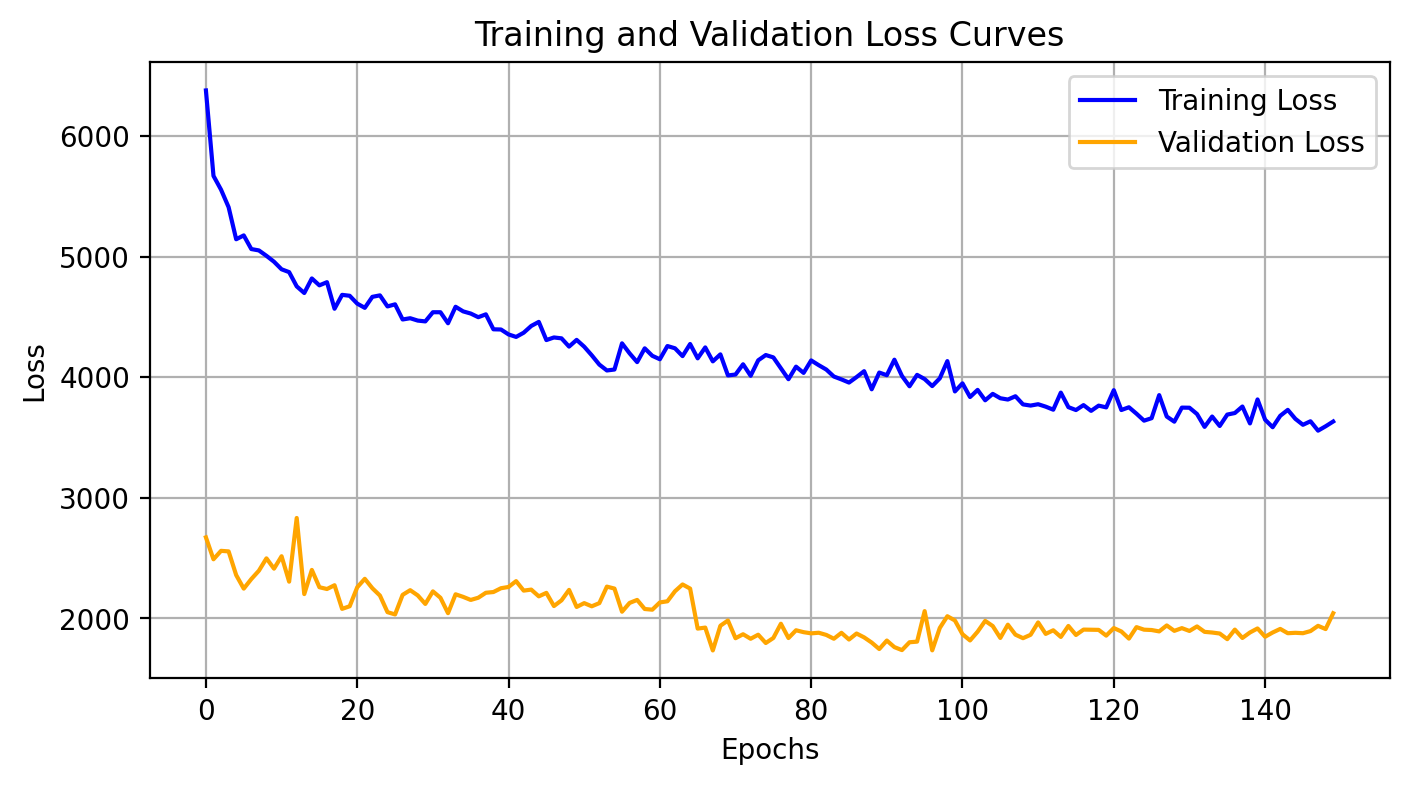

Mean ADE: 3.037435531616211


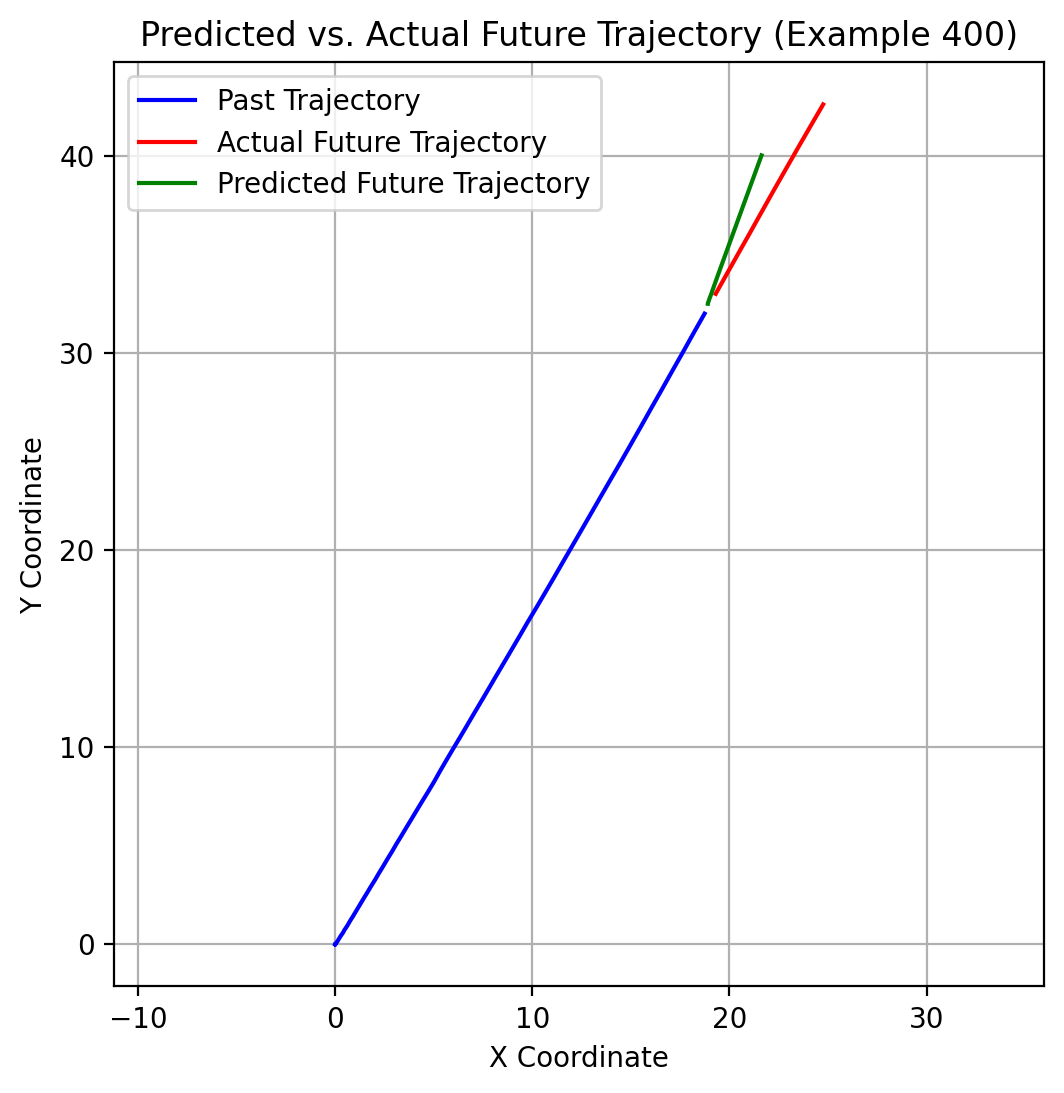

In [39]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

# This is the for all the features
# data = data[:, :, 1:]

#This is for vehicle features only
# data = data[:, :, 1:6]

# This is for vehicle + pedestrians only
data = data[:, :, 1:8]


# This is for vehicle + pedestrians + roadgraphs
# another_data = data[:, :, 1:8]
# new_data = data[:, :, 10:]
# data = np.concatenate((another_data, new_data), axis = 2)


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


#Kavya and Srishti
# External Actors added
import math
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5):
        super(TrajectoryLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_features = output_features
        self.output_timesteps = output_timesteps
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer

        # Attention mechanism
        self.attention = nn.Linear(hidden_size, 1)  # To compute attention scores
        self.softmax = nn.Softmax(dim=1)  # For normalizing attention scores

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(32, output_features * output_timesteps)
        )

    def positional_encoding(self, seq_length, dim):
        # Create the positional encoding matrix
        pos = torch.arange(seq_length, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(dim, dtype=torch.float32).unsqueeze(0)

        # Compute sinusoidal functions
        angle_rates = 1 / (10000 ** (2 * (i // 2) / dim))
        angle_rads = pos * angle_rates

        # Apply sin to even indices and cos to odd indices
        pos_enc = torch.zeros((seq_length, dim))
        pos_enc[:, 0::2] = torch.sin(angle_rads[:, 0::2])  # sin for even indices
        pos_enc[:, 1::2] = torch.cos(angle_rads[:, 1::2])  # cos for odd indices

        return pos_enc

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Add positional encoding
        pos_enc = self.positional_encoding(seq_length, self.input_size).to(x.device)
        x = x + pos_enc.unsqueeze(0)  # Broadcast to batch size

        # LSTM forward pass
        lstm_out, (hn, _) = self.lstm(x)

        # Compute attention scores
        attn_scores = self.attention(lstm_out)  # (batch_size, seq_length, 1)
        attn_weights = self.softmax(attn_scores)  # Normalize to get weights

        # Apply attention weights to LSTM outputs
        weighted_output = lstm_out * attn_weights  # (batch_size, seq_length, hidden_size)
        context_vector = torch.sum(weighted_output, dim=1)  # Sum across seq_length

        # Apply dropout and fully connected layers
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)  # (batch_size, output_timesteps * output_features)
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.2):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        # total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        total_loss = 2 * position_loss + velocity_loss + 0.5 * smoothness_loss + 2 * terminal_position_loss

        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            # added this to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)

            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 128  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()
